In [ ]:
# default_exp animations

# Renderers

> This module implements different types of renderers used to decorate a single type of optimisations. The most common and usefull one is the `derivative_based_optimisation` renderer that is used to illustrate the progress of optimisers such as `Adam` or `SGD`.

In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#exporti
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import HTML, display
from itertools import cycle
from typing import List, Union
from cycler import cycler
from functools import partial
from mpl_toolkits.mplot3d.art3d import Line3D, Poly3DCollection
import numpy as np
from itertools import islice

from optimisations.functions import Ifunction
from optimisations.graphics import plot_function
from optimisations.graphics import rotate

interactive(children=(IntSlider(value=45, description='azimuth', max=135, min=-45), IntSlider(value=45, descri…

## Figure object

In [ ]:
#exports
class Figure:
    """
    This is a wrapper class that binds all the elements of a plot
    """
    def __init__(self, fig=None, ax_3d=None, ax_2d=None, angle=225, contour_log_scale=True, legend_location="upper right", azimuth_3d=30, zoom_factor=0, force_line_zorder=True, credits=None):
        self.fig = fig
        self.ax_3d = ax_3d
        self.ax_2d = ax_2d
        self.angle = angle
        self.contour_log_scale = contour_log_scale
        self.legend_location = legend_location
        self.azimuth_3d = azimuth_3d
        self.zoom_factor = zoom_factor
        self.force_line_zorder = force_line_zorder
        self.credits = credits
        
    def for_function(self, function: Ifunction):
        self.fig, self.ax_3d, self.ax_2d = plot_function(function, fig=self.fig, angle=self.angle, contour_log_scale=self.contour_log_scale, zoom_factor=self.zoom_factor)
        return self

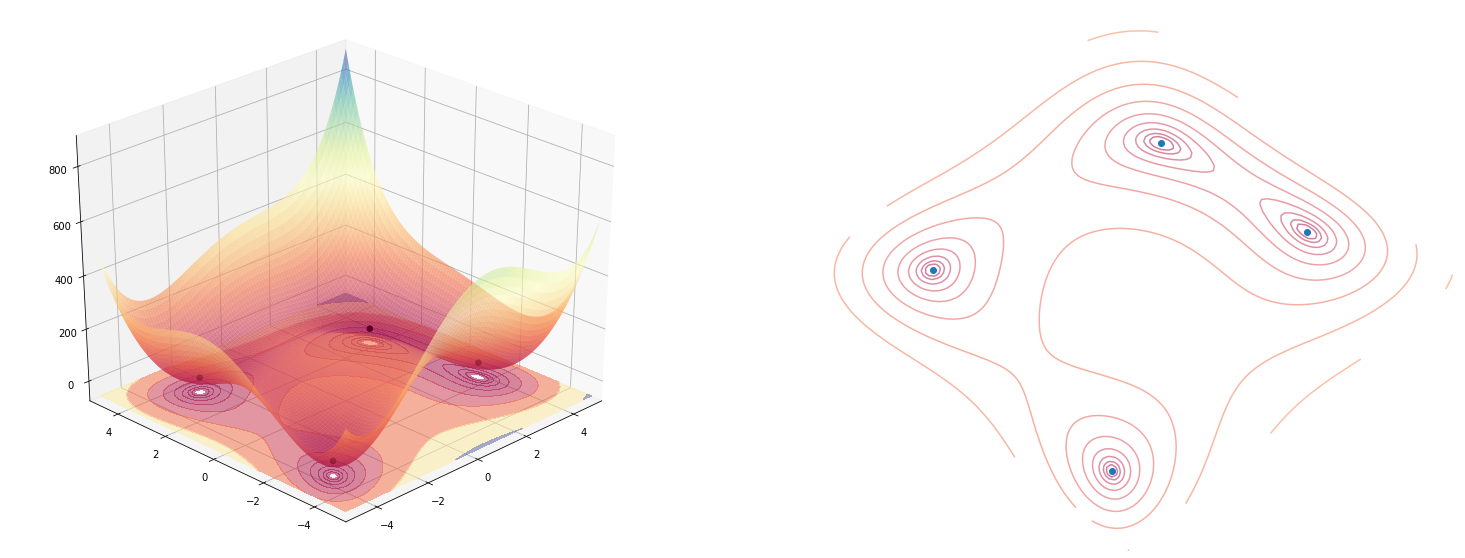

In [ ]:
from optimisations.functions import himmelblau
Figure().for_function(himmelblau());

## Derivative based optimizations' renderer

In [ ]:
#exporti
from itertools import cycle
from typing import List
from functools import partial
from mpl_toolkits.mplot3d.art3d import Line3D, Poly3DCollection

class FixZorderLine3D(Line3D):
    @property
    def zorder(self):
        return 1000

    @zorder.setter
    def zorder(self, value):
        pass

def nth(iterable, n, default=None):
    """
    Returns the nth item or a default value
    """
    return next(islice(iterable, n, None), default)

In [ ]:
#exporti
COLORS = dict()

def get_color_of(name: str):
    global COLORS
    if name not in COLORS:
        color = nth(cycle('bgrcmyk'), len(COLORS))
        COLORS[name] = color
    else:
        color = COLORS.get(name)

    return color

In [ ]:
for i in range(10):
    assert get_color_of("first") == 'b', f"Expecting `get_color_of('first')` to be 0 but was {get_color_of('first')}"
    assert get_color_of("second") == 'g', f"Expecting `get_color_of('second')` to be 1 but was {get_color_of('second')}"
    assert get_color_of("third") == 'r', f"Expecting `get_color_of('third')` to be 0 but was {get_color_of('third')}"

In [ ]:
#export
def decorate_with_derivative_based_plot(name_of_optimizer: str, history: np.ndarray, figure: Figure):
    """
    Decorates the given figure with the illustration of the progress made so far
    by the given optimiser. This function also increments one step into the optimisation process.  

    Note: This decorating function should be used for derivative based optimisers as it only draws
    a single point for each time-step. Other optimisers could be displayed diffrently.
    """
    # we expect the `history` to be a list of (x, y, z) coordinates (so a single point per histrical timestep)
    
    x, y, z = list(zip(*history))
    x, y, z = np.array(x), np.array(y), np.array(z)

    #choose the color of this optimisere based on the `name_of_optimizer` string (should be the same every time, for the same optimiser) 
    color = get_color_of(name_of_optimizer)

    # draw the line paths
    figure.ax_2d.plot(*rotate(x, y, angle=figure.angle), color=color, label=name_of_optimizer)
    lines = figure.ax_3d.plot3D(x, y, z, color=color, label=name_of_optimizer)
    
    # force the lines to be drawn on top (for the 3D plot)
    if figure.force_line_zorder:
        for line in lines:
            line.__class__ = FixZorderLine3D

    #draw the last points
    figure.ax_2d.scatter(*rotate(x[-1:], y[-1:], angle=figure.angle), color=color)
    figure.ax_3d.scatter3D(x[-1:], y[-1:], z[-1:], color=color)
    
    # add a legend to the chart
    figure.ax_2d.legend(loc=figure.legend_location)
    
    if figure.credits:
        # add a credits watermark such as not to overlap with the legend
        if figure.legend_location == "upper right":
            figure.ax_2d.text(1, 0, figure.credits, transform=figure.ax_2d.transAxes, ha='right',
                    color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
        else:
            figure.ax_2d.text(1, 1, figure.credits, transform=figure.ax_2d.transAxes, ha='right',
                    color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

Basic usage, where you only draw some 3D points on the given function contour

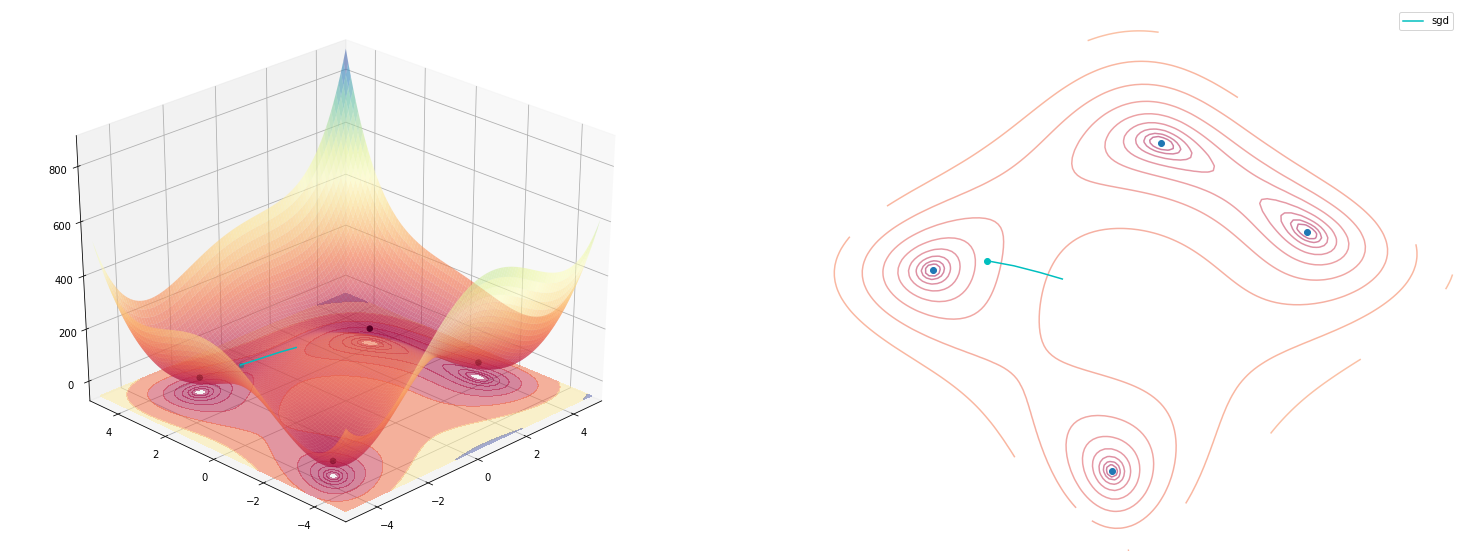

In [ ]:
from optimisations.functions import himmelblau

points = [(-1.0, 1.0, 130.0), (-1.2200000286102295, 1.4600000381469727, 101.89687437358154), (-1.491150140762329, 1.9765945672988892, 67.25343321212884), (-1.8050510883331299, 2.4750380516052246, 34.91699689586346)]

decorate_with_derivative_based_plot(
    "sgd",
    points,
    Figure().for_function(himmelblau())
)

Show two distinct traces on the same graph

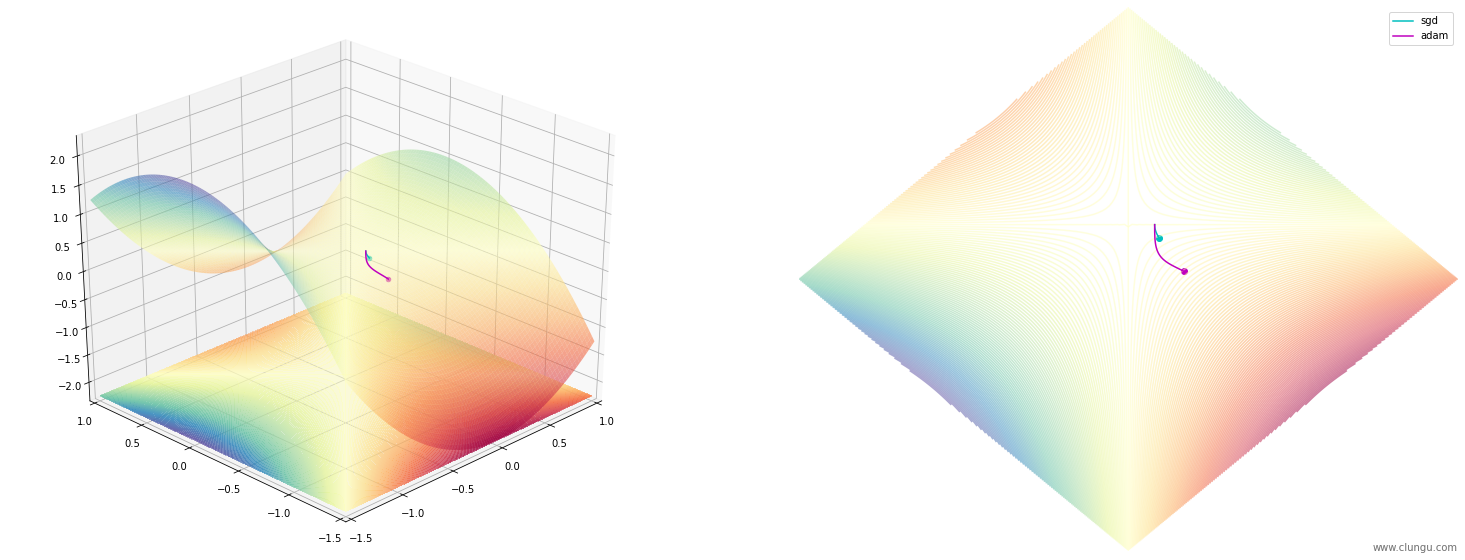

In [ ]:
from jax.experimental.optimizers import sgd, adam
from optimisations.functions import saddle_point

figure = Figure(credits="www.clungu.com", contour_log_scale=False).for_function(saddle_point())


# first optimiser
points = [(0.1, -0.1, 0.0), (0.09800000488758087, -0.10199999809265137, -0.0007999986529350078), (0.09604000300168991, -0.1040399968624115, -0.0016006387705659875), (0.09411920607089996, -0.10612079501152039, -0.0024031981824605975), (0.09223682433366776, -0.10824321210384369, -0.0032089612033978088), (0.0903920903801918, -0.11040807515382767, -0.004019213055872495), (0.08858425170183182, -0.11261623352766037, -0.004835246404383042), (0.0868125632405281, -0.11486855894327164, -0.0056583646973131785), (0.08507630974054337, -0.1171659305691719, -0.006489876807071138), (0.08337478339672089, -0.1195092499256134, -0.0073311063113326025), (0.08170729130506516, -0.12189943343400955, -0.00818339041912175), (0.08007314801216125, -0.12433741986751556, -0.00904808494673337), (0.07847168296575546, -0.12682417035102844, -0.009926565157748646), (0.07690224796533585, -0.12936066091060638, -0.010820224849106885), (0.07536420226097107, -0.13194787502288818, -0.011730478740623163), (0.07385692000389099, -0.13458682596683502, -0.012658769091365984), (0.07237978279590607, -0.13727855682373047, -0.013606569206023655), (0.07093218713998795, -0.1400241255760193, -0.014575380570866547), (0.06951354444026947, -0.14282460510730743, -0.01556673496340899), (0.06812327355146408, -0.14568109810352325, -0.01658220194528076), (0.06676080822944641, -0.1485947221517563, -0.01762338593590873), (0.06542558968067169, -0.15156660974025726, -0.018691929403091834), (0.06411708146333694, -0.1545979380607605, -0.019789522317262553), (0.0628347396850586, -0.1576898992061615, -0.020917899800360296), (0.06157804653048515, -0.16084370017051697, -0.022078840070032565), (0.06034648418426514, -0.164060577750206, -0.023274175018329624), (0.05913955345749855, -0.16734178364276886, -0.024505785769590935), (0.057956762611866, -0.17068861424922943, -0.02577561670187406), (0.05679762735962868, -0.17410238087177277, -0.027085668551536587), (0.055661674588918686, -0.1775844246149063, -0.028438005847764666), (0.054548442363739014, -0.1811361163854599, -0.029834760094896717)]
decorate_with_derivative_based_plot(
    "sgd",
    points,
    figure
)

# second optimiser
points = [(0.1, -0.1, 0.0), (0.09000007063150406, -0.10999993234872818, -0.003999972403049057), (0.08004139363765717, -0.12001331150531769, -0.007996570243014034), (0.0701589286327362, -0.1300487071275711, -0.011990390958659392), (0.060394302010536194, -0.14011424779891968, -0.01598453072091721), (0.05079684406518936, -0.15021741390228271, -0.019984952072506557), (0.041424207389354706, -0.16036508977413177, -0.024000997060429075), (0.03234272450208664, -0.17056356370449066, -0.02804587743535797), (0.02362709864974022, -0.1808185875415802, -0.032137121809927546), (0.015359243378043175, -0.19113530218601227, -0.036296797384592266), (0.007625732570886612, -0.20151835680007935, -0.040551496330161405), (0.0005139955319464207, -0.21197181940078735, -0.04493178802867315), (-0.0058929515071213245, -0.22249941527843475, -0.04947126292178008), (-0.011522291228175163, -0.23310434818267822, -0.0542048739465244), (-0.016317199915647507, -0.2437894344329834, -0.059167037328066704), (-0.020241431891918182, -0.2545571029186249, -0.06438960308128822), (-0.023281902074813843, -0.2654094696044922, -0.06990013959151664), (-0.02544892579317093, -0.2763483226299286, -0.07572074759634878), (-0.02677435800433159, -0.2873750925064087, -0.08186757754652284), (-0.027308328077197075, -0.2984910011291504, -0.08835113297271063), (-0.02711528353393078, -0.3096970021724701, -0.09517699455348949), (-0.026270100846886635, -0.3209938108921051, -0.10234690843253094), (-0.024854645133018494, -0.33238187432289124, -0.10985995699370998), (-0.02295498177409172, -0.34386152029037476, -0.11771381394815893), (-0.020659219473600388, -0.3554328680038452, -0.12590572030818048), (-0.018055865541100502, -0.36709585785865784, -0.13443335457654562), (-0.015232520177960396, -0.3788502514362335, -0.1432954833423254), (-0.012274766340851784, -0.390695720911026, -0.15249247644946382), (-0.009265068918466568, -0.4026317596435547, -0.16202649237160127), (-0.006281677633523941, -0.4146578311920166, -0.17190165749497544), (-0.003397418651729822, -0.42677319049835205, -0.18212381367464756)]
decorate_with_derivative_based_plot(
    "adam",
    points,
    figure
)

Shows how you would integrate this with an `optimize` object that uses a real optimizer and updates for 30 times.

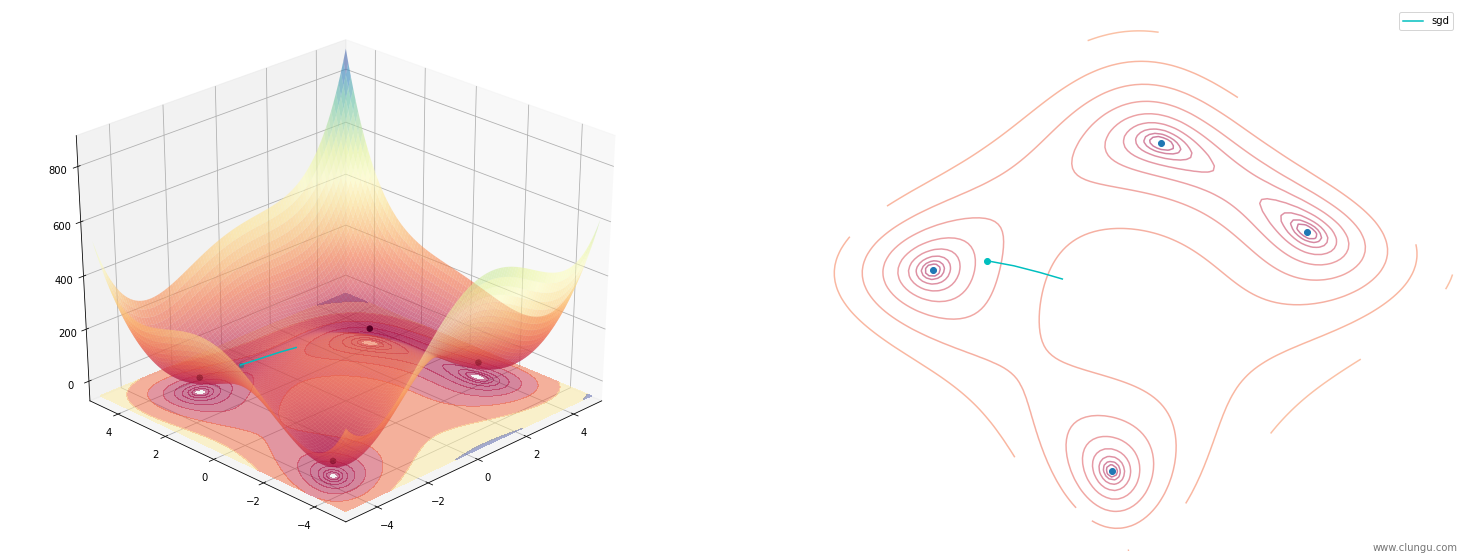

In [ ]:
from jax.experimental.optimizers import sgd
from optimisations.functions import himmelblau
from optimisations.optimizers import optimize

function = himmelblau()
figure = Figure(credits="www.clungu.com").for_function(function)

optimisation = (
    optimize(function)
        .using(sgd(step_size=0.01), name="sdg")
        .start_from([-1., 1.])
) 
history = optimisation.update(3)
points = np.array([np.asarray(optimisation._get_params(state)) for state in history])
points = [(x, y, optimisation.function(x, y)) for x, y in points]

decorate_with_derivative_based_plot(
    "sgd",
    points,
    figure
)